    eps  min_samples  silhouette  davies_bouldin  dunn_index
0   0.1            2   -0.078111        1.280875         0.0
1   0.1            3   -0.207813        1.336808         0.0
2   0.1            4   -0.255337        1.350586         0.0
3   0.1            5   -0.306143        1.336352         0.0
4   0.1            6   -0.341172        1.347251         0.0
..  ...          ...         ...             ...         ...
76  0.9            6    0.141692        1.570755         0.0
77  0.9            7    0.132396        1.650240         0.0
78  0.9            8    0.109031        1.761295         0.0
79  0.9            9    0.076002        1.716906         0.0
80  0.9           10    0.081461        1.710128         0.0

[81 rows x 5 columns]


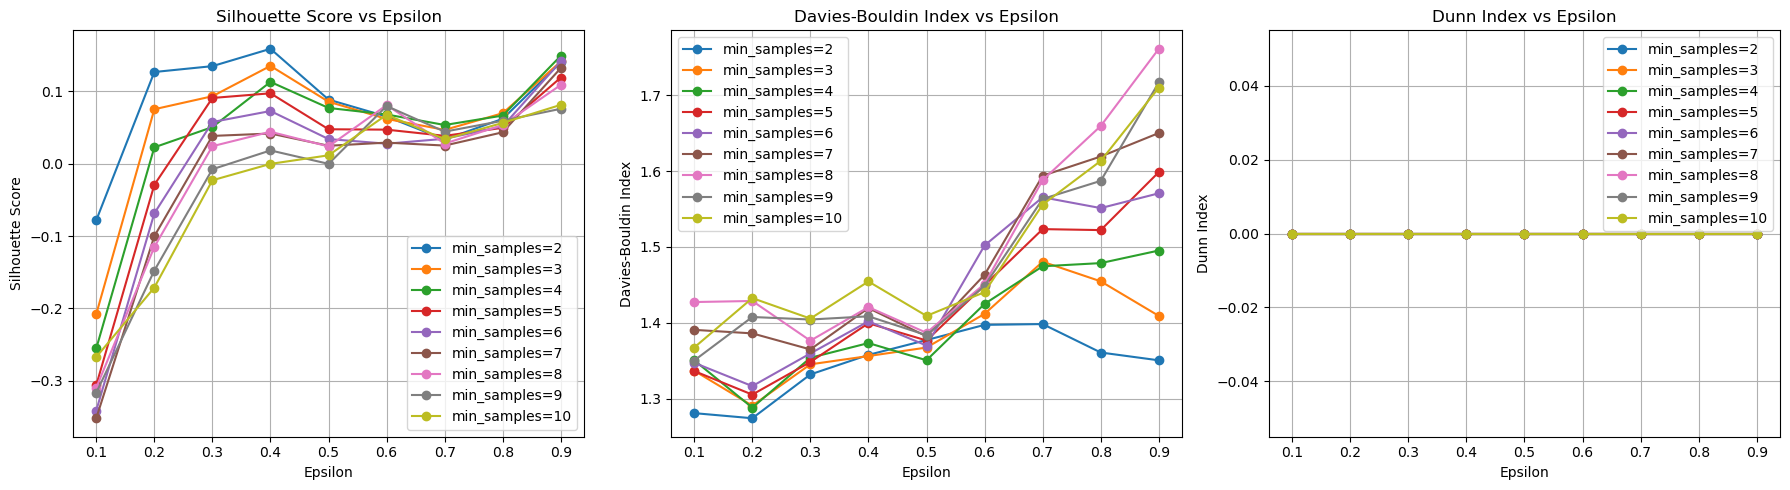

In [1]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load your dataset (ensure column headers are as expected)
data = pd.read_csv(r'E:\UoB\Semester 1\DAPM\Assignments\Assignment 2\CSV Files Step by Step\Step 3 Clustering.csv')

# Select numeric columns for clustering
numeric_data = data[['Age', 'Height', 'Weight', 'family_history', 'Meals', 'Smoker', 'Alcohol']]

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(numeric_data)

# Function to calculate Dunn Index
def dunn_index(data_scaled, labels):
    unique_clusters = np.unique(labels)
    inter_cluster_distances = []
    intra_cluster_distances = []
    
    # Ignore noise points (label = -1)
    unique_clusters = unique_clusters[unique_clusters != -1]
    if len(unique_clusters) < 2:
        return np.nan  # Dunn Index is not defined for single or no clusters
    
    # Calculate inter-cluster distances
    for i, j in itertools.combinations(unique_clusters, 2):
        cluster_i = data_scaled[labels == i]
        cluster_j = data_scaled[labels == j]
        min_distance = np.min(pdist(np.vstack([cluster_i, cluster_j]), 'euclidean'))
        inter_cluster_distances.append(min_distance)
    
    # Calculate intra-cluster distances
    for cluster in unique_clusters:
        cluster_data = data_scaled[labels == cluster]
        if len(cluster_data) > 1:
            max_distance = np.max(pdist(cluster_data, 'euclidean'))
            intra_cluster_distances.append(max_distance)
        else:
            intra_cluster_distances.append(0)
    
    if len(inter_cluster_distances) > 0 and len(intra_cluster_distances) > 0:
        dunn = min(inter_cluster_distances) / max(intra_cluster_distances)
        return dunn
    return np.nan

# Hyperparameter ranges
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = range(2, 11)

# Results storage
results = []

# Loop through all combinations of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data_scaled)
        
        # Only calculate metrics if there are clusters
        if len(set(labels)) > 1 and -1 in labels:
            silhouette = silhouette_score(data_scaled, labels) if len(set(labels)) > 1 else np.nan
            db_index = davies_bouldin_score(data_scaled, labels) if len(set(labels)) > 1 else np.nan
            dunn = dunn_index(data_scaled, labels)
        else:
            silhouette = np.nan
            db_index = np.nan
            dunn = np.nan
        
        # Append results
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'silhouette': silhouette,
            'davies_bouldin': db_index,
            'dunn_index': dunn
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

# Visualize the metrics
plt.figure(figsize=(18, 5))

# Silhouette Score
plt.subplot(1, 3, 1)
for min_samples in min_samples_values:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['silhouette'], marker='o', label=f'min_samples={min_samples}')
plt.title('Silhouette Score vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid()

# Davies-Bouldin Index
plt.subplot(1, 3, 2)
for min_samples in min_samples_values:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['davies_bouldin'], marker='o', label=f'min_samples={min_samples}')
plt.title('Davies-Bouldin Index vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Davies-Bouldin Index')
plt.legend()
plt.grid()

# Dunn Index
plt.subplot(1, 3, 3)
for min_samples in min_samples_values:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['dunn_index'], marker='o', label=f'min_samples={min_samples}')
plt.title('Dunn Index vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Dunn Index')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
